## M13

### Test starfinders

In [1]:
import os 
import numpy as np 
import matplotlib.pyplot as plt 
from astropy.io import fits 
from astropy.stats import * 
from photutils.background import Background2D, MedianBackground, MMMBackground
from photutils.detection import DAOStarFinder 
from photutils.aperture import CircularAperture
from photutils.aperture import aperture_photometry

In [2]:
#First define the image in python as a string.
imagefile = "M13_g_align.fit" 
image = fits.open(imagefile)[0].data
header = fits.open(imagefile)[0].header

In [3]:
print(image.shape)

(2042, 3054)


/var/folders/ts/_gjzk30d5ggbnzxtbzmvs2240000gn/T/ipykernel_94833/1794141150.py:2: RuntimeWarning: invalid value encountered in log
  plt.imshow(np.log(image), #We usually take the log of an image to see the variance of the pixels better.


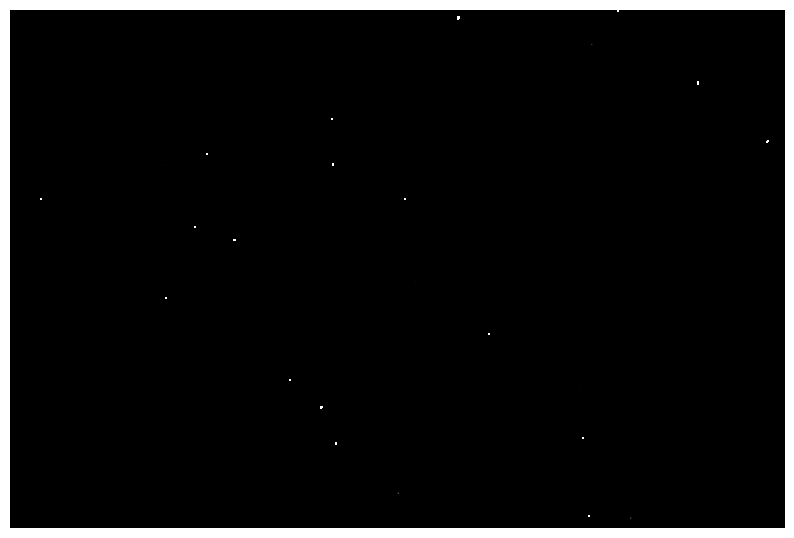

In [4]:
plt.figure(figsize=(10,10))
plt.imshow(np.log(image), #We usually take the log of an image to see the variance of the pixels better.
            origin='lower', #This tells matplotlib where the [0,0] index is. For our images it is in the bottom.
            cmap = "gray", #Use whatever colormap you like, but I find gray the easiest to visualize.
            vmin = 6, vmax = 11) #This defines the data range we want to see. There are ways to automate this but I always do it manually.
plt.axis('off') #This removes the axes, which aren't really relevant for just viewing an image.
plt.show()

In [5]:
mjd = header['MJD-OBS']
print("The Modified Julian Date is", mjd)

The Modified Julian Date is 60067.9566047


In [45]:
sigma_clip = SigmaClip(sigma=3, cenfunc='mean') #doesn't change much for inf sigma
mean, median, std = sigma_clipped_stats(image,sigma=3, cenfunc='mean') 

bkg_estimator = MedianBackground() 
bkg = Background2D(image, 
                    box_size=(50, 50), 
                    filter_size=(9, 9), 
                    sigma_clip=sigma_clip, 
                    bkg_estimator=bkg_estimator) 
bkg_ = bkg.background
bkg_median = bkg.background_median
bkg_rms = bkg.background_rms_median

mmm_bkg = MMMBackground()

daofind = DAOStarFinder(fwhm=3, #smaller <1, more bright stars
                        threshold=std*4,
                        #brightest= 200
                       ) 
sources = daofind(image - bkg_median) #doesn't change if not subtract bkg
print(sources)


 id      xcentroid      ...        flux                 mag         
---- ------------------ ... ------------------ ---------------------
   1  43.79695981035774 ...  1.064501166343689  -0.06786535404682248
   2  1773.707986455734 ... 21.894123077392578   -3.3508188878331175
   3 1330.8923957974564 ... 1.0511635541915894  -0.05417573668491892
   4    2616.0557472381 ... 1.0570448637008667   -0.0602335506816252
   5  2742.806198262361 ...  2.348836898803711   -0.9271321519814696
   6 1401.2362838341917 ... 1.0249907970428467  -0.02679991515881915
   7  2790.710111744914 ... 1.0889453887939453  -0.09251525049102462
 ...                ... ...                ...                   ...
1158  3.298233128018678 ... 1.0060172080993652 -0.006513523665281533
1159  732.2703620550558 ... 3.0458528995513916   -1.2092723127858749
1160 144.90507974995387 ...  1.159446120262146   -0.1606264291868003
1161 1835.0590967044193 ...  3.653639793395996   -1.4068143217917164
1162 2394.9260339815037 ... 38.575

In [7]:
image_ = (image - bkg_median)
brightest = sorted(image_.flatten())[:18]
print(mean, median, std, sorted(image_.flatten())[:10])
print(bkg_median,bkg_rms)
print(np.where(image==brightest))
print(np.nanstd(image))

34.757893 34.711033 3.5849087 [-1577.5228, -930.7493, -529.2719, -386.74762, -365.0378, -316.5013, -315.49536, -287.75565, -252.10417, -224.36296]
34.608394622802734 3.438891382966965
(array([], dtype=int64),)
16.197168


/var/folders/ts/_gjzk30d5ggbnzxtbzmvs2240000gn/T/ipykernel_94833/1379437242.py:5: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  print(np.where(image==brightest))


/var/folders/ts/_gjzk30d5ggbnzxtbzmvs2240000gn/T/ipykernel_94833/2386951899.py:6: RuntimeWarning: invalid value encountered in log
  plt.imshow(np.log(image), origin='lower', cmap = "gray", vmin=4, vmax = 11)


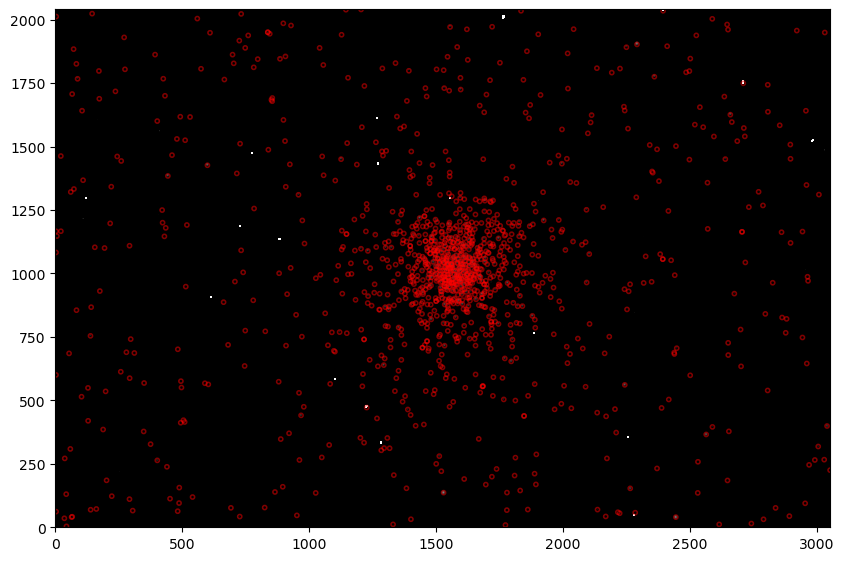

In [47]:
positions = np.transpose((sources['xcentroid'], sources['ycentroid'])) #Positions are transposed by default.
apertures = CircularAperture(positions, r=3) #This defines an 'aperture' by radius around each source. The pixel values inside the aperture are summed to yield the photon count of the star.

#Lets plot our image again with the apertures overplotted to see how many stars we found.
plt.figure(figsize=(10,10))
plt.imshow(np.log(image), origin='lower', cmap = "gray", vmin=4, vmax = 11)
v = apertures.plot(color='red', lw=3, alpha=0.5) 
plt.show()

In [28]:
for bright in brightest:
    positions = list(positions)
    positions.append(np.where(image==bright))
    
positions = np.array(positions)
print(positions.shape)

(111, 2)


/var/folders/ts/_gjzk30d5ggbnzxtbzmvs2240000gn/T/ipykernel_32093/942857213.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  positions = np.array(positions)


/var/folders/ts/_gjzk30d5ggbnzxtbzmvs2240000gn/T/ipykernel_32093/902176125.py:6: RuntimeWarning: invalid value encountered in log
  plt.imshow(np.log(image), origin='lower', cmap = "gray", vmin=4, vmax = 11)


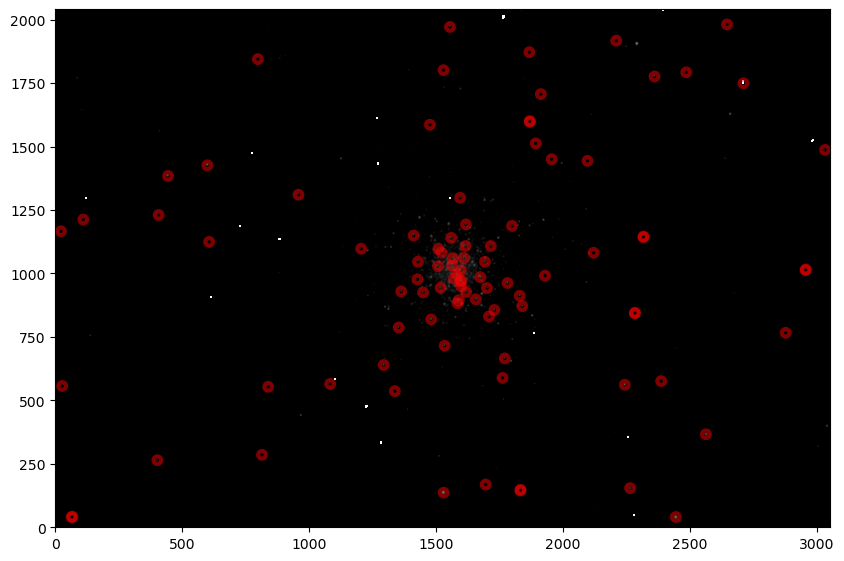

In [29]:
positions = np.transpose((sources['xcentroid'], sources['ycentroid'])) #Positions are transposed by default.
apertures = CircularAperture(positions, r=15) #This defines an 'aperture' by radius around each source. The pixel values inside the aperture are summed to yield the photon count of the star.

#Lets plot our image again with the apertures overplotted to see how many stars we found.
plt.figure(figsize=(10,10))
plt.imshow(np.log(image), origin='lower', cmap = "gray", vmin=4, vmax = 11)
v = apertures.plot(color='red', lw=3, alpha=0.5) 
plt.show()

In [18]:
import sep
datasw = image.byteswap(False).newbyteorder()
bkg0=sep.Background(datasw)
data_sub=datasw-bkg0
objects = sep.extract(datasw-bkg0.back(), bkg0.globalrms*3, minarea =10, segmentation_map=False)

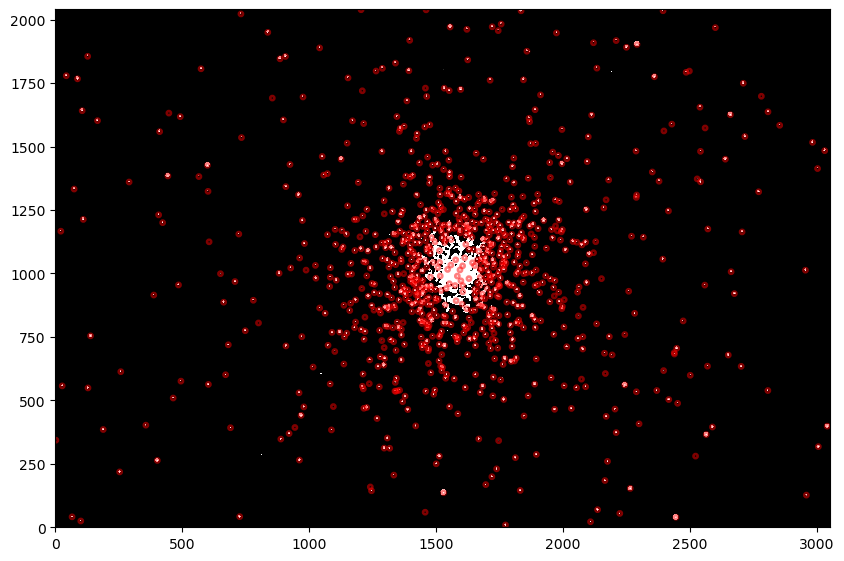

In [67]:
positions = np.transpose((objects['x'], objects['y'])) #Positions are transposed by default.
apertures = CircularAperture(positions, r=5) #This defines an 'aperture' by radius around each source. The pixel values inside the aperture are summed to yield the photon count of the star.

#Lets plot our image again with the apertures overplotted to see how many stars we found.
plt.figure(figsize=(10,10))
plt.imshow(data_sub, origin='lower', cmap = "gray", vmin=10, vmax = 11)
v = apertures.plot(color='red', lw=3, alpha=0.5) 
plt.show()

In [66]:
print(objects['b'][-10:-1],objects['b'].std(), np.median(objects['b']),
      objects['a'].mean(),objects['b'].std(), np.median(objects['a'])  )

[1.78134358 0.75457978 1.62149477 2.45948362 0.77108264 0.87938434
 0.82455385 1.61427605 1.18602836] 1.1252473729034587 1.689403772354126 2.441825503038757 1.1252473729034587 1.9435429573059082


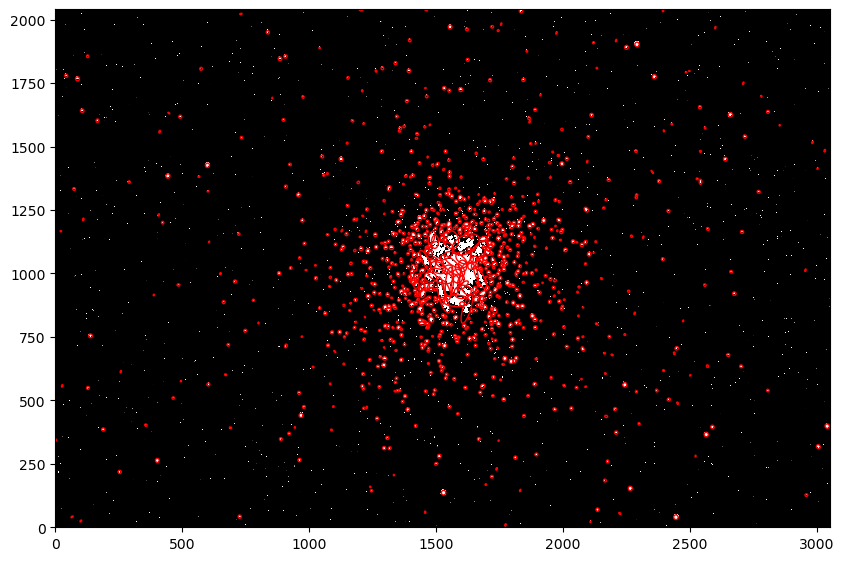

In [34]:
from matplotlib.patches import Ellipse
# plot background-subtracted image
fig, ax = plt.subplots(figsize=(10,10))
m, s = np.mean(data_sub), np.std(data_sub)
im = ax.imshow(data_sub, interpolation='nearest', cmap='gray',
vmin=10, vmax=11, origin='lower')
# plot an ellipse for each object
for i in range(len(objects)):
  e = Ellipse(xy=(objects['x'][i], objects['y'][i]),
  width=6*objects['a'][i],
  height=6*objects['b'][i],
  angle=objects['theta'][i] * 180. / np.pi)
  e.set_facecolor('none')
  e.set_edgecolor('red')
  ax.add_artist(e)

In [32]:
print(np.median(objects['flux']),objects['flux'].std())
print(objects['flux'][np.where(objects['flux']>1500)].shape)

1149.3243408203125 12764.971827415044
(340,)


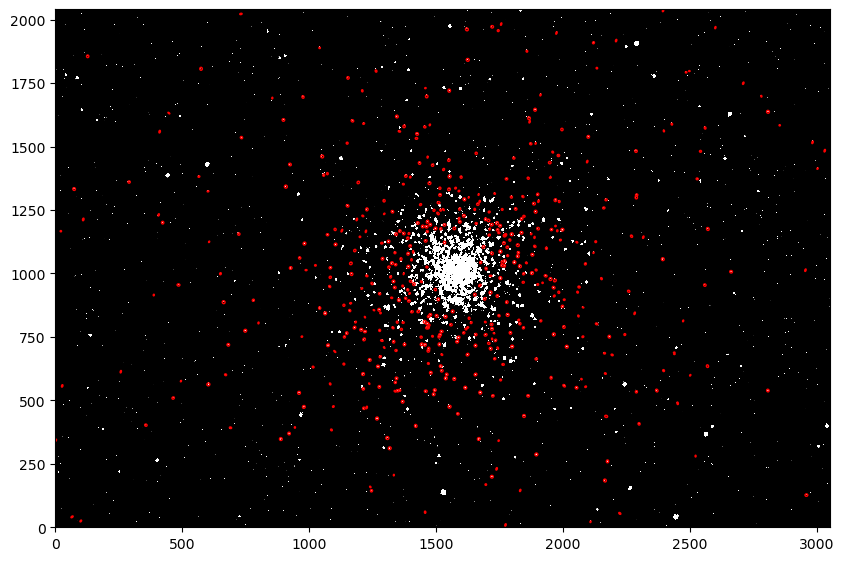

In [65]:
fig, ax = plt.subplots(figsize=(10,10))
m, s = np.mean(data_sub), np.std(data_sub)
im = ax.imshow(data_sub, interpolation='nearest', cmap='gray',
vmin=10, vmax=11, origin='lower')
# plot an ellipse for each object
for i in range(len(objects)):
    e = Ellipse(xy=(objects['x'][i], objects['y'][i]),
    width=6*objects['a'][i],
    height=6*objects['b'][i],
    angle=objects['theta'][i] * 180. / np.pi)
    e.set_facecolor('none')
    e.set_edgecolor('red')
    if objects['a'][i]<=2 and objects['b'][i]<=2.44:
        ax.add_artist(e)
    else:
        None

### Photometry

In [80]:
import mplhep as hep

In [76]:
def photometry(data, data2):
    datasw = data.byteswap(False).newbyteorder()
    bkg0=sep.Background(datasw)
    data_sub=datasw-bkg0
    objects = sep.extract(datasw-bkg0.back(), bkg0.globalrms*3, minarea =10, segmentation_map=False)
    positions = np.transpose((objects['x'], objects['y']))
    apertures = CircularAperture(positions, r=5)
    phot_table = aperture_photometry(data_sub, apertures)
    aperture_sums = phot_table['aperture_sum']
    
    data2sw = data2.byteswap(False).newbyteorder()
    bkg02=sep.Background(data2sw)
    data_sub02=data2sw-bkg02
    phot_table2 = aperture_photometry(data_sub02, apertures)
    aperture_sums2 = phot_table2['aperture_sum']
    return positions, aperture_sums, aperture_sums2

In [77]:
imagefile_g = "M13_g_align.fit" 
aligned_g = fits.open(imagefile_g)[0].data
header_g = fits.open(imagefile_g)[0].header

imagefile_r = "M13_r_align.fit" 
aligned_r = fits.open(imagefile_r)[0].data
header_r = fits.open(imagefile_r)[0].header

In [78]:
positions, sums_g, sums_r = photometry(aligned_g, aligned_r)

In [82]:
color = []
Gmag = []
Rmag = []
for i in range(len(positions)):
        mag_g = -2.5*np.log10(sums_g[i])
        mag_r = -2.5*np.log10(sums_r[i])
        color.append(mag_g-mag_r)
        Gmag.append(mag_g)
        Rmag.append(mag_r)

/var/folders/ts/_gjzk30d5ggbnzxtbzmvs2240000gn/T/ipykernel_94833/1219305492.py:6: RuntimeWarning: invalid value encountered in log10
  mag_r = -2.5*np.log10(sums_r[i])


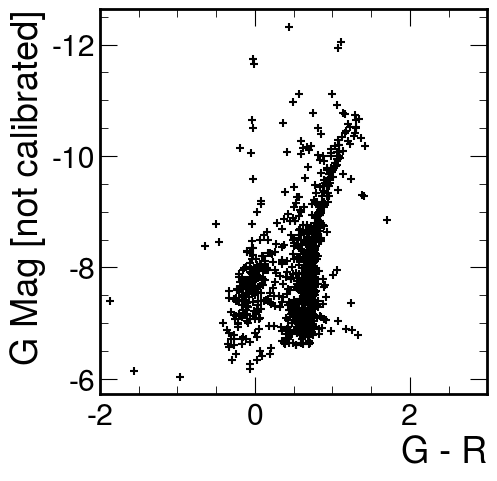

In [87]:
plt.figure(figsize=(5,5))
plt.style.use(hep.style.ROOT)
plt.scatter(np.array(color), Gmag, marker='+', color='k')
plt.xlabel('G - R')
plt.ylabel('G Mag [not calibrated]')
plt.xlim(-2, 3)
plt.gca().invert_yaxis()